# Aula 2 - Separabilidade Não Linear e *Support Vector Machines*

Na aula de hoje vamos continuar o tema iniciado na aula passada, e vamos acrescentar algumas complexidades ao problema:

- 1. Separabilidade Não-Linear
- 2. Feature Maps
- 3. Funções de Kernel
- 4. SVM não lineares
- 5. SVM para Regressão

## 1. Separabilidade Não Linear

Recapitulando o que falamos na aula passada:

> Um conjunto de dados é dito **linearmente separável** se existe algum hiperplano que divide perfeitamente os registros entre as categorias existentes. Nesse caso, o hiperplano é conhecido como *classificador de margem*.

Vimos também que o classificador de margem máxima é aquele com maior potencial de generalização, mas que no caso de conjuntos de dados muito ruidosos ou com valores extremos, pode ser necessário um grau de folga na margem, sendo característico do *classificador de margem suave*, também conhecido como *Support Vector Machine* ou SVM. O classificador de margem suave introduz um pouco mais de viés, porém com grande potencial de diminuir a variância do modelo.

Em todos os casos (margem fixa ou margem suave), a fronteira de decisão será sempre linear no espaço dos atributos.

No entanto, vamos considerar o seguinte caso de conjunto de dados unidimensional

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/e00c77e0-14fb-472f-b9ae-f6af7b229ad5.PNG width=400>

É evidente que este dataset **não é linearmente separável**! Portanto, não conseguimos produzir um classificador de vetores de suporte para este dataset **no espaço de features original**.

## 2. Feature Maps

Mas, aí entra uma ideia muito interessante: e se nós **levarmos os dados para um ou outro espaço?**

Seria possível que no espaço original os dados não sejam linearmente separáveis, mas **o sejam** em algum outro espaço?

Bom, a priori, vamos tentar algo bem simples... Que tal introduzirmos **uma nova feature** $X_2 = X_1^2$? O que aconteceria neste caso?

De fato, ao **introduzirmos** uma nova feature, estamos fazendo com que **cada observação passe a ser caracterizada por duas features ao invés de uma única**!

Ou seja, nosso espaço de features efetivamente muda de $\mathbb{R}^1$ para $\mathbb{R}^2$! Veja:

<img src=https://s3-sa-east-1.amazonaws.com/lcpi/8d5e6199-8a33-45cf-9e4f-c6507024fb36.PNG width=800>

O procedimento que fizemos é chamado de **feature map**, e ele é matematicamente representado pelo mapa (função) $\Phi$. 

> Como $\Phi$ leva observações do espaço original ( $1$ D, uma única feature $X_1$, para vetores do novo espaço ($2$ D, duas features, $X_1$ e $X_2$), o denotamos como: 
$$\begin{align*}
\Phi \ \colon \ & \mathbb{R}^1 \longrightarrow \mathbb{R}^2 \\
& \vec{x} = X_1 \longmapsto \Phi(\vec{x}) = (X_1, X_2)
\end{align*}$$

Um pouco mais de terminologia:

> O "espaço original" é comumente chamado de **espaço de input** (representaremos por $\mathcal{X}$); enquanto o espaço após a aplicação do feature map é chamado de **espaço de features (representaremos por $\mathcal{Z}$)**

<img src=https://miro.medium.com/max/872/1*zWzeMGyCc7KvGD9X8lwlnQ.png width=400>

Também é comum se referir ao espaço de features como **espaço z**, devido à comum notação $\Phi(\vec{x}) \equiv \vec{z}$. Neste caso, teríamos:

$$\begin{align*}
\Phi \ \colon \ & \mathbb{R}^1 \longrightarrow \mathbb{R}^2 \\
& \vec{x} = X_1 \longmapsto \Phi(\vec{x}) = \vec{z} = (Z_1, Z_2)
\end{align*}$$

Uma vez que temos estas definições, podemos perceber a real utilidade do feature map: **os dados não eram linearmente separáveis no espaço de input, mas passaram a ser no espaço de features!**

Isso é realmente formidável, pois, se temos dados linearmente separáveis, podemos **treinar um classificador de margem suave** no espaço de features!

Isso pode parecer estranho, pois, afinal, gostaríamos de separar os dados no espaço original, não é mesmo?

Na verdade, nosso objetivo é que os dados sejam separados, **não importa em que espaço**! Se conseguirmos encontrar um espaço onde há separabilidade através da aplicação de um feature map, bastaria **aplicar o mesmo feature map** aos dados de treino e de teste, e a separabilidade sempre estará garantida!

In [10]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets._samples_generator import make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# ignorando warnings
warnings.filterwarnings('ignore')

In [11]:
# gerando alguns dados
np.random.seed(42)
data = pd.DataFrame({'x1': np.random.normal(0,1,50)})
data['y'] = data.x1.apply(lambda x: 1 if abs(x) > 1.1 else 0)

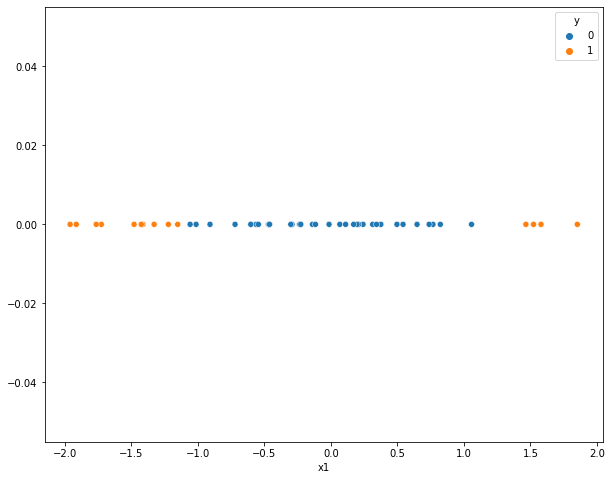

In [12]:
# visualizando os dados
plt.figure(figsize=(10,8))
sns.scatterplot(data = data, x = 'x1', y = np.zeros(data.shape[0]), hue = 'y')
plt.show()

In [13]:
# adiciona features
data['x2'] = data.x1**2

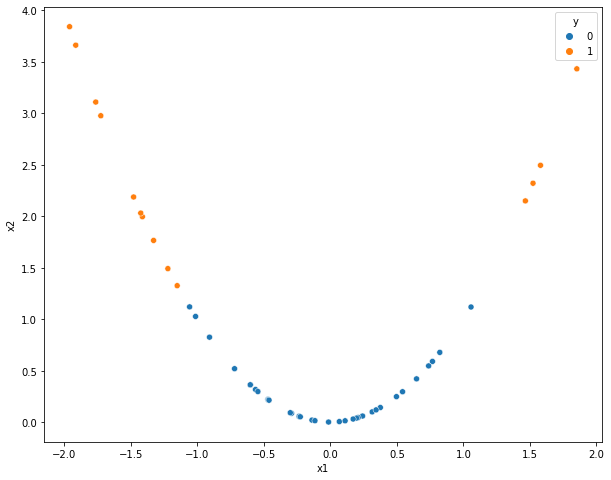

In [14]:
# visualizando os novos dados
plt.figure(figsize=(10,8))
sns.scatterplot(data = data, x = 'x1', y = 'x2', hue = 'y')
plt.show()

Vejamos mais um exemplo, agora projetando um 2D para 3D

$$\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, e^{-|x_1^2 + x_2^2|})$$

In [15]:
# definindo a função de mapeamento
def feature_map_2(X):  
    return np.asarray((X[:,0], X[:,1], np.exp( -( X[:,0]**2 + X[:,1]**2)))).T

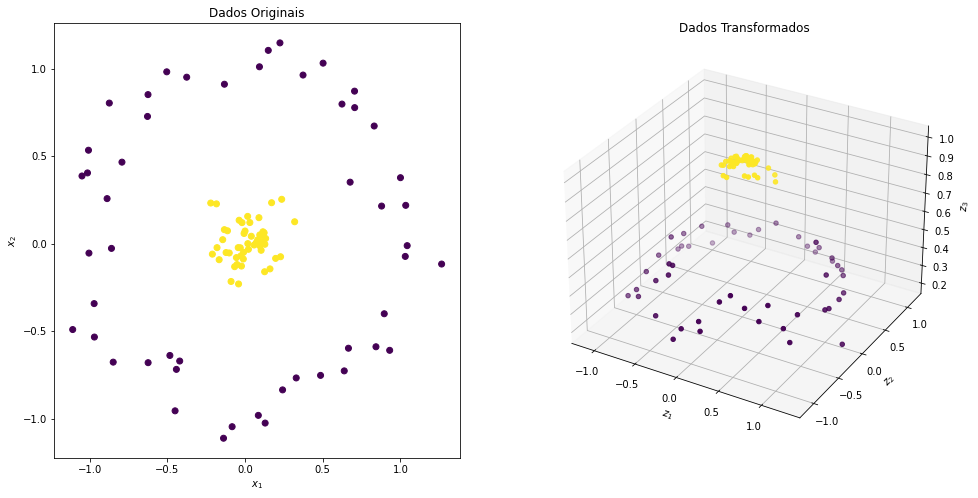

In [16]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_2(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Dados Originais')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Dados Transformados')

plt.show()

> Uma **Support Vector Machine** nada mais é que **um classificador de margem suave** treinado **no espaço de features**. Portanto, este classificador pressupõe a aplicação prévia de um **feature map** aos dados no espaço de input.

## 3. Funções de Kernel

Da discussão acima, ficou claro que é justamente o feature map que dá grande poder às SVMs. De fato, a possibilidade de conseguirmos separabilidade linear é algo formidável!

Neste contexto, uma pergunta natural é: como escolher um bom feature map? Formalmente, existem infinitos feature maps possíveis! Como escolher, dentre infinitas opções, exatamente o mapa exato que nos garante separabilidade linear no espaço de features? Embora esta pergunta não seja fácil de responder, existem algumas técnicas para nos ajudar a escolher bons feature maps (vamos discutir sobre isso mais a diante).

Além disso, existe um segundo problema, ainda maior: suponha que queiramos introduzir um kernel que leva os pontos para um espaço de features de altíssima dimensionalidade (algo como $\Phi : \mathbb{R}^2 \mapsto \mathbb{R}^{10000}$).

É de se esperar que este seja um feature map **operacionalmente custoso** de ser calculado, não é mesmo? Imagina, ter que aplicar esta transformação para todos os pontos de treino, e depois de teste! De fato, isso rapidamente se torna computacionalmente impraticável...

Pra solucionar este problema, foi introduzido o uso de **funções de kernel** para capturar um aspecto importante dos feature maps!

Mas, pra entendermos a importância das funções de kernel, é necessário entendermos uma coisa:

> A hipótese do SVM depende apenas do **produto interno** entre as observações no espaço de features!!

Uma função de kernel $\kappa$ nada mais é que uma **medida de similaridade** entre dois vetores $\vec{x}$ e $\vec{x}'$ (que no nosso caso, são observações). Definimos como:

$$\boxed{\begin{align*}
\kappa \ \colon \ & \mathcal{X} \times \mathcal{X} \longrightarrow \mathbb{R} \\
& (\vec{x}, \vec{x}') \longmapsto \kappa(\vec{x}, \vec{x}')
\end{align*}}$$

Ou seja, um kernel é uma função que, dadas duas observações $\vec{x}$ e $\vec{x}'$, retorna um número real que caracteriza o quão similar as duas observações são entre si.

**Ponto fundamental**: uma função de kernel permite que **o produto escalar** entre duas observações seja calculado **no espaço de features**, sem que precisemos **explicitamente levar as observações pro espaço de features**.

Ou seja, conseguimos **evitar** que o feautre map, que costuma ser custoso computacionalmente, seja explicitamente aplicado!

E uma vez que pro SVM apenas o produto interno interessa, podemos usar diretamente a função de kernel, que é muito mais computacionalmente simples que o feature map explícito!

Esse é o chamado **kernel trick**.

### Tipos de Kernel Functions

Da mesma forma que existem infinitos feature maps possíveis, a variedade de kernels também é imensa! Apesar dos kernels oferecerem uma vantagem operacional absurda com relação à aplicação explícita do feature map, o problema de escolha de um kernel adequado para um determinado problema ainda existe.

Na prática, existem algumas formas de propor kernels, mas este não é um tema fácil. Existe todo um conjunto de métodos e técnicas que se utilizam de kerneles para tarefas de aprendizagem, os chamados [métodos de kernel](https://en.wikipedia.org/wiki/Kernel_method).

Apesar da enorme liberdade no design de kernels, há algumas classes particulares de kernels que são comumente utilizados:

- Linear kernel: $\kappa_\Phi(\vec{x}, \vec{x}') = \langle \vec{x}, \vec{x}'\rangle $
<br><br>
- Polynomial kernel: $\kappa_\Phi(\vec{x}, \vec{x}') = (\gamma \langle \vec{x}, \vec{x}'\rangle + r)^d$
<br><br>
- Radial Basis Function (RBF) kernel: $\kappa_\Phi(\vec{x}, \vec{x}') = \exp(-\gamma \|\vec{x}-\vec{x}'\|^2)$
<br><br>
- Sigmoid kernel: $\kappa_\Phi(\vec{x}, \vec{x}') = \tanh(\gamma \langle \vec{x},\vec{x}'\rangle + r)$

Note que a dependência funcional dos kernels muda, dependendo exatamente do feature map específico que eles representam.

## 4. SVM não lineares

Para o desenvolvimento, vamos usar a classe `SVC` do pacote `scikit-learn`, cuja documentação está [nesse link](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Para a construção de um modelo SVM, é muito importante que os dados sejam normalizados!

O motivo é bem simples: como vimos acima, o SVM é completamente baseado no kernel, que por sua vez é dado por um produto interno. Já o produto interno, é altamente dependente da **escala das features** (lembre-se, $\langle \Phi(\vec{x}) , \Phi(\vec{x}') \rangle = \left | \Phi(\vec{x}) \right | \left | \Phi(\vec{x}') \right | \cos \left ({\theta_{\vec{x}, \vec{x}'}} \right )$, isto é, a norma dos vetores influencia o produto interno!).

Portanto, para evitar que efeitos de escala influenciem a classificação, a normalização é um passo extremamente importante!

In [17]:
# exemplo de aplicação do Polynomial Kernel
X, y = make_moons(n_samples=500, noise=0.15, random_state=42)

In [18]:
# criando o pipeline de modelos
poly_kernel_svm_clf = Pipeline([
    ("std_scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [19]:
# funções auxiliares
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=.1)

def plot_datasets(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which="both")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

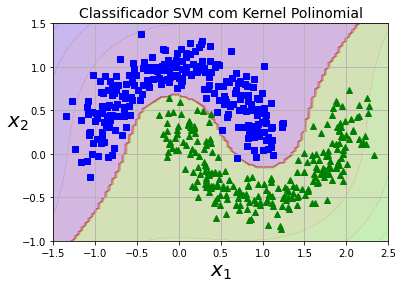

In [20]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_datasets(X, y, [-1.5, 2.5, -1, 1.5])
plt.title("Classificador SVM com Kernel Polinomial", fontsize=14)
plt.show()

### Aplicando Validação cruzada para selecionar o Kernel e os parâmetros

In [21]:
# importando os dados
iris = load_iris(as_frame=True)

# criando um dataframe
data = pd.DataFrame(iris.data, columns = iris.feature_names)
data['species'] = iris.target
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [22]:
# separando preditores e preditos
x = data.drop(['species'], axis = 1)
y = data[['species']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    stratify = y, random_state = 19)

In [23]:
# criando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# criando o pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# criando o dicionário de distribuições
param_dict = {
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': np.linspace(0.1, 10, 100),
    'svm__gamma': np.linspace(0.1,1,100),
    'svm__degree': [2, 3]
}

In [24]:
# criando e treinando a seleção de hiperparâmetros
hyp_tun = RandomizedSearchCV(pipe, 
                             param_dict, 
                             n_iter=100, 
                             cv=cvs,
                             scoring='accuracy', 
                             refit=True, random_state=2)
hyp_tun.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm', SVC())]),
                   n_iter=100,
                   param_distributions={'svm__C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,...
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272727,
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
                                        'svm__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=2, scoring='accuracy')

In [25]:
# verificando melhores parâmetros e melhor métrica
print('Melhores parâmetros: ', hyp_tun.best_params_)
print('Melhor acurácia média: ', hyp_tun.best_score_)

# realizando novas predições
yhat = hyp_tun.best_estimator_.predict(x_test)

# relatório de classificação
print(classification_report(y_test, yhat))

Melhores parâmetros:  {'svm__kernel': 'linear', 'svm__gamma': 0.22727272727272727, 'svm__degree': 3, 'svm__C': 2.4000000000000004}
Melhor acurácia média:  0.9666666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



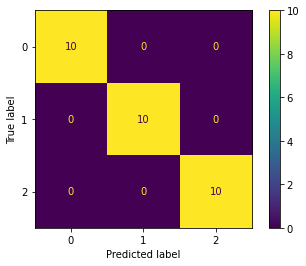

In [26]:
# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

#### Exercício 1

Aplique o conceito de SVM não linear para classificação do conjunto de dados de qualidade dos vinhos. No entanto, faça a seguinte transformação na variável `quality`:

- **Vinhos com notas 3 e 4**: vinho "ruim" - classe 0
- **Vinhos com notas 5 e 6**: vinho "comum" - classe 1
- **Vinhos com notas 7 e 8**: vinho "bom" - classe 2

## 5. SVM para Regressão

Embora fizemos nossa apresentação do SVM como um classificador, também é possível utilizar este método para regressão!

Todos os elementos do classificador SVM (margem, kernel, etc.) também são relevantes aqui.

A ideia é bem simples: utilização de um kernel para que um modelo de **regressão linear seja treinado no espaço de features**. No espaço de inputs, este modelo é refletido como uma regressão não-linear (da mesma forma que, no caso de classificação, fronteiras de decisão lineares no espaço de features são refletidas como fronteiras não-lineares no espaçõ de input).

A principal diferença é que o conceito de margem também está presente, de modo que **apenas alguns pontos efetivamente vão contriuir para a regressão**. Neste caso, são os pontos **dentro da margem** (região conhecida como $\epsilon-$ tubo) que serão estes vetores de suporte. Ou seja, pontos que estão fora da margem não contribuem para a função de custo.

<img src=https://www.saedsayad.com/images/SVR_5.png width=600>

Uma comparação entre classificadores e regressores SVM:

<img src=https://miro.medium.com/max/1100/1*XE9jt0r1yAW8LnliQ3mllQ.png width=600>

#### Exercício 2

Sabendo que a classe do `scikit-learn` que implementa a regressão com SVM é a `SVR`, implemente um modelo de regressão para o dataset Steel_industry_data e faça as seguintes análises:

- Elimine as seguintes colunas: `Date`, `WeekStatus` e `Day_of_week`
- Sua variável-alvo é a coluna: `Usage_kWh`
- Checar dados nulos. Se houver, eliminá-los
- Separe 30 % dos dados para teste
- Use o Random Search para selecionar os hiperparâmetros (**Cuidado** com o número de hiperparâmetros pois o conjunto de dados é grande)
- Use um objeto `KFold` para validação cruzada (use 5 folds)
- As métricas de seleção podem ser o $R^2$ ou o MAE
- Utilize o modelo do `Pipeline`
- Não se esqueça de aplicar o escalonamento dos dados (`StandardScaler`)

In [34]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.spatial import ConvexHull

# ignorar warnings
warnings.filterwarnings('ignore')

In [3]:
# importando a base de dados dos vinhos
df = pd.read_csv('Steel_industry_data.csv')
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
df.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [23]:
# separando entre preditores e preditos
x = df.drop(['date', 'WeekStatus', 'Day_of_week', 'Usage_kWh', 'Load_Type'], axis = 1)
y = df[['Usage_kWh']]

In [24]:
# separando o conjunto treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [25]:
# criando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# criando o pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC())])

# criando o dicionário de distribuições
param_dict = {
    'svm__penalty': ['l1', 'l2'],
    'svm__C': np.linspace(1, 5, 10000)
}

In [36]:
y.value_counts()

Usage_kWh
3.06         631
2.95         609
2.92         598
3.02         560
2.88         556
            ... 
93.42          1
93.82          1
94.03          1
94.28          1
157.18         1
Length: 3343, dtype: int64

In [35]:
# criando e treinando a seleção de hiperparâmetros
hyp_tun = RandomizedSearchCV(pipe, 
                            param_dict, 
                            n_iter=100, 
                            scoring='neg_mean_absolute_error', 
                            refit=True, random_state=2)
hyp_tun.fit(x_train, y_train)

ValueError: Unknown label type: 'continuous'

In [30]:
sklearn.metrics.SCORERS.keys()

NameError: name 'sklearn' is not defined

In [ ]:
# verificando melhores parâmetros e melhor métrica
print('Melhores parâmetros: ', hyp_tun.best_params_)
print('Melhor acurácia média: ', hyp_tun.best_score_)